##$$\textrm{Classification}$$

## 1. 기본 설정

In [46]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize)

- 분류에 사용되는 여러 알고리즘 패키지 장착


- 플롯과 데이터 전 처리를 위한 함수를 장착

In [47]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import  (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


## 2. Smarket Data 분석
- 데이터를 불러옴
- 불러온 데이터에서 Direction을 수치화 한 다음에 상관행렬을 계산함
- 변수 중 하나인 Volume을 그려봄

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')
               Year      Lag1      Lag2      Lag3      Lag4      Lag5  \
Year       1.000000  0.029700  0.030596  0.033195  0.035689  0.029788   
Lag1       0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675   
Lag2       0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558   
Lag3       0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808   
Lag4       0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084   
Lag5       0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000   
Volume     0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002   
Today      0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860   
Direction  0.074608 -0.039757 -0.024081  0.006132  0.004215  0.005423   

             Volume     Today  Direction  
Year       0.539006  0.030095   0.074608  
Lag1       0.040910 -0.026155  -0.039757  
Lag2      -0.043383 -0.

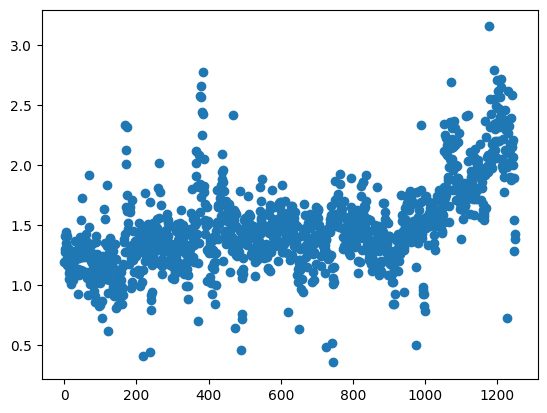

In [48]:
Smarket = load_data('Smarket')
Smarket
print(Smarket.columns)
import copy

Smar = copy.deepcopy(Smarket)
Smar['Direction'] = Smar['Direction'].map({'Up': 1, 'Down': 0})

print(Smar.corr())
plt.plot(Smar['Volume'], 'o')
plt.show()

- 반응변수를 비롯한 몇 개의 변수를 제외
- MS는 데이터 전처리를 위한 함수
- 문자로 되어 있는 Direction변수를 0,1로 변환
- 로지스틱 회귀분석 적용

In [49]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == "Up"
print(y)
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(summarize(results))

0        True
1        True
2       False
3        True
4        True
        ...  
1245     True
1246    False
1247     True
1248    False
1249    False
Name: Direction, Length: 1250, dtype: bool
             coef  std err      z  P>|z|
intercept -0.1260    0.241 -0.523  0.601
Lag1      -0.0731    0.050 -1.457  0.145
Lag2      -0.0423    0.050 -0.845  0.398
Lag3       0.0111    0.050  0.222  0.824
Lag4       0.0094    0.050  0.187  0.851
Lag5       0.0103    0.050  0.208  0.835
Volume     0.1354    0.158  0.855  0.392


- 예측된 화률을 살펴봄
- 만약이 예측화률이 0.5초과하면 Up으로 예측
- 훈련 데이터의 예측에 대한 혼동행렬을 계산함
- 예측정확도를 계산함  

In [50]:
probs = results.predict()
probs[:10]
labels = np.array(['Down']*1250)
labels[probs>0.5] = "Up"
print(confusion_table(labels, Smarket.Direction))
np.mean(labels == Smarket.Direction)

Truth      Down   Up
Predicted           
Down        145  141
Up          457  507


0.5216

- 훈련 데이터를 쪼갬 (기준은 2005년 전과 후)

- 훈련 데이터로 학습한 모형으로부터 평가 데이터의 예측확률을 저장
- 이로부터 혼동행렬과 예측정확도를 계산

In [51]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train,family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [52]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
print(confusion_table(labels, L_test))
np.mean(labels != L_test)

Truth      Down  Up
Predicted          
Down         77  97
Up           34  44


0.5198412698412699



- 전체 변수가 아닌 Lag1과 Lag2만으로 로지스틱 회귀분석을 진행
- 혼동행렬을 통해서 예측정확도 파악



In [53]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
print(confusion_table(labels, L_test))
np.mean(labels == L_test)

Truth      Down   Up
Predicted           
Down         35   35
Up           76  106


0.5595238095238095

즉 데이터를 다쓰는건 좋지않다.?


- 새로운 데이터가 들어왔을 때, 예측 확률을 계산


- 모두다 0.5보다 작으므로 0으로 예측하게 됨

In [54]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
print(results.predict(newX))

0    0.479146
1    0.496094
dtype: float64


##3. LDA \& QDA

- 앞에서 불러들인 데이터를 이용
- LDA로 예측변수들이 주어졌을 때, 0과 1의 확률을 계산
- 0과 1의 종류별로 평균 벡터와 공유하는 공분산 행렬 그리고 각 종에 대한 prior를 보여줌
- 여기에서 prior는 실제 0과 1의 비율을 의미  

In [55]:
lda = LDA(store_covariance=True)
XX_train, XX_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]

a, c = np.unique(L_train, return_counts=True)
print(c/np.sum(c))

lda.fit(XX_train, L_train)
print(lda.means_)
print(lda.covariance_)
print(lda.classes_)
print(lda.priors_)

[0.49198397 0.50801603]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[[ 1.50886781 -0.03340234]
 [-0.03340234  1.5095363 ]]
['Down' 'Up']
[0.49198397 0.50801603]


마지막은 다운의 비중과 up의 비중을 각각 


- LDA를 이용한 예측 결과 및 혼동행렬

In [56]:
lda_pred = lda.predict(XX_test)
print(lda_pred)
print(confusion_table(lda_pred, L_test))

['Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up' 'Down' 'Down'
 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down'
 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Down' 'Down'
 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Down' 'Down' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up'
 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down'
 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Down'
 'Down' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up'
 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'

In [57]:
lda_prob = lda.predict_proba(XX_test)
print(lda_prob)

[[0.49017925 0.50982075]
 [0.4792185  0.5207815 ]
 [0.46681848 0.53318152]
 [0.47400107 0.52599893]
 [0.49278766 0.50721234]
 [0.49385615 0.50614385]
 [0.49510156 0.50489844]
 [0.4872861  0.5127139 ]
 [0.49070135 0.50929865]
 [0.48440262 0.51559738]
 [0.49069628 0.50930372]
 [0.51199885 0.48800115]
 [0.48951523 0.51048477]
 [0.47067612 0.52932388]
 [0.47445929 0.52554071]
 [0.47995834 0.52004166]
 [0.49357753 0.50642247]
 [0.50308938 0.49691062]
 [0.49788061 0.50211939]
 [0.48863309 0.51136691]
 [0.50065681 0.49934319]
 [0.51087353 0.48912647]
 [0.50399248 0.49600752]
 [0.49163351 0.50836649]
 [0.50417721 0.49582279]
 [0.50267505 0.49732495]
 [0.49140429 0.50859571]
 [0.48059641 0.51940359]
 [0.48827181 0.51172819]
 [0.50621869 0.49378131]
 [0.50059958 0.49940042]
 [0.49729649 0.50270351]
 [0.49585462 0.50414538]
 [0.48117774 0.51882226]
 [0.48414175 0.51585825]
 [0.47263882 0.52736118]
 [0.48364175 0.51635825]
 [0.50910066 0.49089934]
 [0.51359414 0.48640586]
 [0.49338391 0.50661609]


- QDA를 이용한 결과
- 여기에서는 공분산 행렬이 공유되지 않고 0과 1별로 별도의 공분산 행렬이 추정됨

In [58]:
qda = QDA(store_covariance=True)
print(qda.fit(XX_train, L_train))

qda.means_, qda.priors_
print(qda.covariance_[0])
print(qda.covariance_[1])

QuadraticDiscriminantAnalysis(store_covariance=True)
[[ 1.50662277 -0.03924806]
 [-0.03924806  1.53559498]]
[[ 1.51700576 -0.02787349]
 [-0.02787349  1.49026815]]


In [ ]:
 1.50662277 -0.03924806]
 [-0.03924806  1.53559498 첫번째 코배리언스 행렬
[[ 1.51700576 -0.02787349]
 [-0.02787349  1.49026815]]두번째 코베리언스 행렬

- QDA로 예측한 결과 및 혼합행렬
- 예측정확도

In [59]:
qda_pred = qda.predict(XX_test)
#print(qda_pred)
print(confusion_table(qda_pred, L_test))
np.mean(qda_pred == L_test)

Truth      Down   Up
Predicted           
Down         30   20
Up           81  121


0.5992063492063492

accuracy =0.5992063492063492
이경우는 lda보다 qda가 더 도움이되는 상황이다.

##4. Naive Bayes


- Naive 베이즈를 이용한 결과
- 여기에서 theta_는 각 종별 평균벡터 var_는 공분산 행렬의 대각값들을 의미 (각 종별 분산)

In [60]:
NB = GaussianNB()
rs = NB.fit(XX_train, L_train)
print(rs)
print(NB.class_prior_)
print(NB.theta_)
print(NB.var_)

GaussianNB()
[0.49198397 0.50801603]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[[1.50355429 1.53246749]
 [1.51401364 1.48732877]]


In [ ]:
대칭이아니라 코베리언스 행렬이 아니다.
[[1.50355429 1.53246749] 첫번째 코베리언스 역할을 하는중
 0으로 취급하니깐 두개의 분산을 써준거다.

- Naive 베이지를 이용한 예측
- 혼합행렬의 결과

In [61]:
nb_labels = NB.predict(XX_test)
print(confusion_table(nb_labels , L_test))

Truth      Down   Up
Predicted           
Down         29   20
Up           82  121


##5. KNN classifier  

- 위 데이터에 적용

In [62]:
knn1 = KNeighborsClassifier(n_neighbors=1) # 금방에있는 것들중 1만 봐라는ㄸ스
knn1.fit(XX_train , L_train)
knn1_pred = knn1.predict(XX_test)
print(confusion_table(knn1_pred , L_test))
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(XX_train , L_train).predict(XX_test)
print(confusion_table(knn3_pred , L_test))

Truth      Down  Up
Predicted          
Down         43  58
Up           68  83
Truth      Down  Up
Predicted          
Down         48  55
Up           63  86


In [ ]:
1만보면 43,83인데 3개를보면 더높아짐 그래서 하나만 보면 문제가있다.

- 데이터를 불러오고 예측을 진행

In [63]:
# data loading
# ------------
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()
feature_df = Caravan.drop(columns=['Purchase'])

scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaler.fit(feature_df)
# 표준화를 위한 평균과 표준편차를 계산
X_std = scaler.transform(feature_df)
# 표준화를 진행

feature_std = pd.DataFrame(X_std , columns=feature_df.columns)
print(feature_std.std())

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64


 - KNN을 이용해서 분류를 하고 그것을 test 테이터에서 성능을 확인

In [64]:
(X_train, X_test, y_train, y_test) = train_test_split(feature_std, Purchase, test_size=1000, random_state=0)
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train , y_train).predict(X_test)

print(np.mean(y_test != knn1_pred)), print(np.mean(y_test != "No"))
print(confusion_table(knn1_pred , y_test))

0.111
0.067
Truth       No  Yes
Predicted          
No         880   58
Yes         53    9


#성능이 엄청나게 좋아짐 거리를 이용하는데 표준화를 하냐안하느냐에 따라 큰 차이가 있다.

- KNN 에서  K의 값에 따른 성능을 비교
  - 전체 예측정확도가 아닌 YES로 예측한 경우의 정확도만 살펴본 것임



In [65]:
for K in range(1,6):
  knn = KNeighborsClassifier(n_neighbors=K)
  knn_pred = knn.fit(X_train , y_train).predict(X_test)
  C = confusion_table(knn_pred, y_test)
  templ = ('K={0:d}: # predicted to rent: {1:>2},' + ' # who did rent {2:d}, accuracy {3:.1%}')
  pred = C.loc['Yes'].sum()
  did_rent = C.loc['Yes','Yes']
  print(templ.format(K, pred, did_rent, did_rent / pred))
  # rent를 한 사람을 맞춘 것에 대한 정확도임
  

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


- 로지스틱 회귀분석에서 분류 기준을 바꾸었을 때의 결과[


In [66]:
  #기준을 바꾸면 한쪽이 좋아지고 다른쪽이 안좋아짐 

logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
print(confusion_table(logit_labels , y_test))
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
print(confusion_table(logit_labels , y_test))

Truth       No  Yes
Predicted          
No         933   67
Yes          0    0
Truth       No  Yes
Predicted          
No         913   58
Yes         20    9


## 6. 제약 및 다양한 회귀분석



In [67]:
from ISLP.models import contrast

# data loading
# ------------
Bike = load_data('Bikeshare')
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [68]:
# 일반 OLS 결과
# -----------
X = MS(['mnth', 'hr', 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
print(summarize(M_lm))
# 가변수의 경우 범주의 수 - 1개의 더미 변수를 구성

                                 coef  std err       t  P>|t|
intercept                    -68.6317    5.307 -12.932  0.000
mnth[Feb]                      6.8452    4.287   1.597  0.110
mnth[March]                   16.5514    4.301   3.848  0.000
mnth[April]                   41.4249    4.972   8.331  0.000
mnth[May]                     72.5571    5.641  12.862  0.000
mnth[June]                    67.8187    6.544  10.364  0.000
mnth[July]                    45.3245    7.081   6.401  0.000
mnth[Aug]                     53.2430    6.640   8.019  0.000
mnth[Sept]                    66.6783    5.925  11.254  0.000
mnth[Oct]                     75.8343    4.950  15.319  0.000
mnth[Nov]                     60.3100    4.610  13.083  0.000
mnth[Dec]                     46.4577    4.271  10.878  0.000
hr[1]                        -14.5793    5.699  -2.558  0.011
hr[2]                        -21.5791    5.733  -3.764  0.000
hr[3]                        -31.1408    5.778  -5.389  0.000
hr[4]   

In [69]:
hr_encode = contrast('hr', 'sum')     # 합에 대한 제약을 검
mnth_encode = contrast('mnth', 'sum') # 합에 대한 제약을 검
X2 = MS([mnth_encode, hr_encode, 'workingday','temp', 'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
print(S2)
# 마지막 범주의 계수는 나머지 계수들의 합에 음수를 취함
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)
# 거의 차이가 없음

                                 coef  std err       t  P>|t|
intercept                     73.5974    5.132  14.340  0.000
mnth[Jan]                    -46.0871    4.085 -11.281  0.000
mnth[Feb]                    -39.2419    3.539 -11.088  0.000
mnth[March]                  -29.5357    3.155  -9.361  0.000
mnth[April]                   -4.6622    2.741  -1.701  0.089
mnth[May]                     26.4700    2.851   9.285  0.000
mnth[June]                    21.7317    3.465   6.272  0.000
mnth[July]                    -0.7626    3.908  -0.195  0.845
mnth[Aug]                      7.1560    3.535   2.024  0.043
mnth[Sept]                    20.5912    3.046   6.761  0.000
mnth[Oct]                     29.7472    2.700  11.019  0.000
mnth[Nov]                     14.2229    2.860   4.972  0.000
hr[0]                        -96.1420    3.955 -24.307  0.000
hr[1]                       -110.7213    3.966 -27.916  0.000
hr[2]                       -117.7212    4.016 -29.310  0.000
hr[3]   

1.481150636351971e-20

In [70]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
print(coef_month)
# 제약조건이 걸린 계수 확인
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])
])
print(coef_month)
# 위 계수의 합에 음수를 취해 마지막 계수를 생성

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64
mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64


- 월에 대응되는 계수둘을 선도표로 연결해서 시각화함

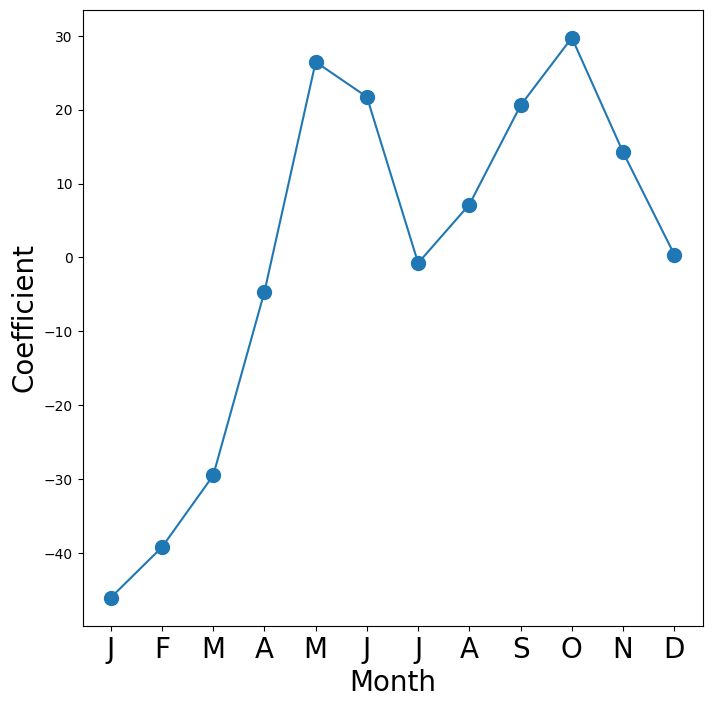

In [71]:
fig_month , ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);

- 시간에 대응되는 계수둘을 선도표로 연결해서 시각화함

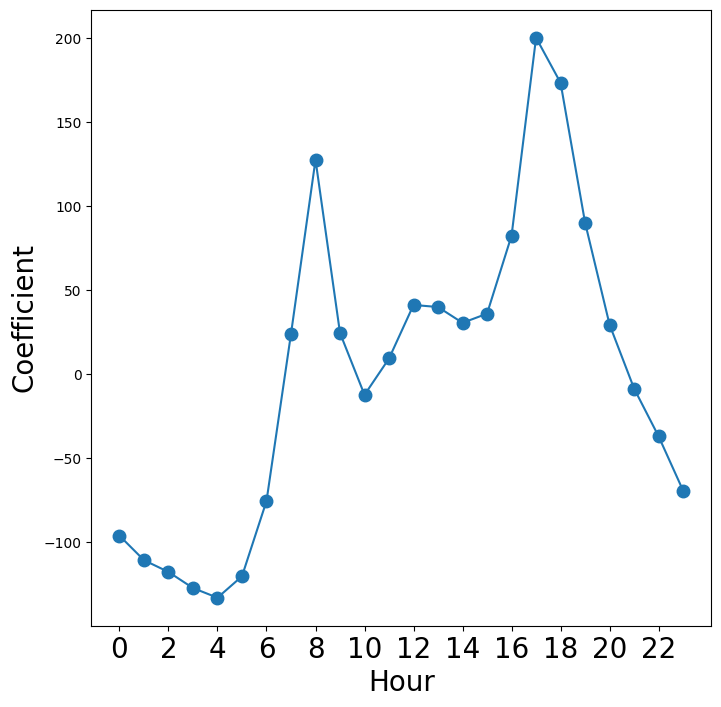

In [72]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])
])
fig_hr , ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr , coef_hr , marker='o', ms=9)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

---------------------------------------------------------------------------------

- 포아송 분포를 가정하고 평균을 추정
   - 월별, 시간에 따른 계수의 값을 선도표화함


/tmp/ipykernel_39640/2887756137.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels(range(24)[::2], fontsize =20)


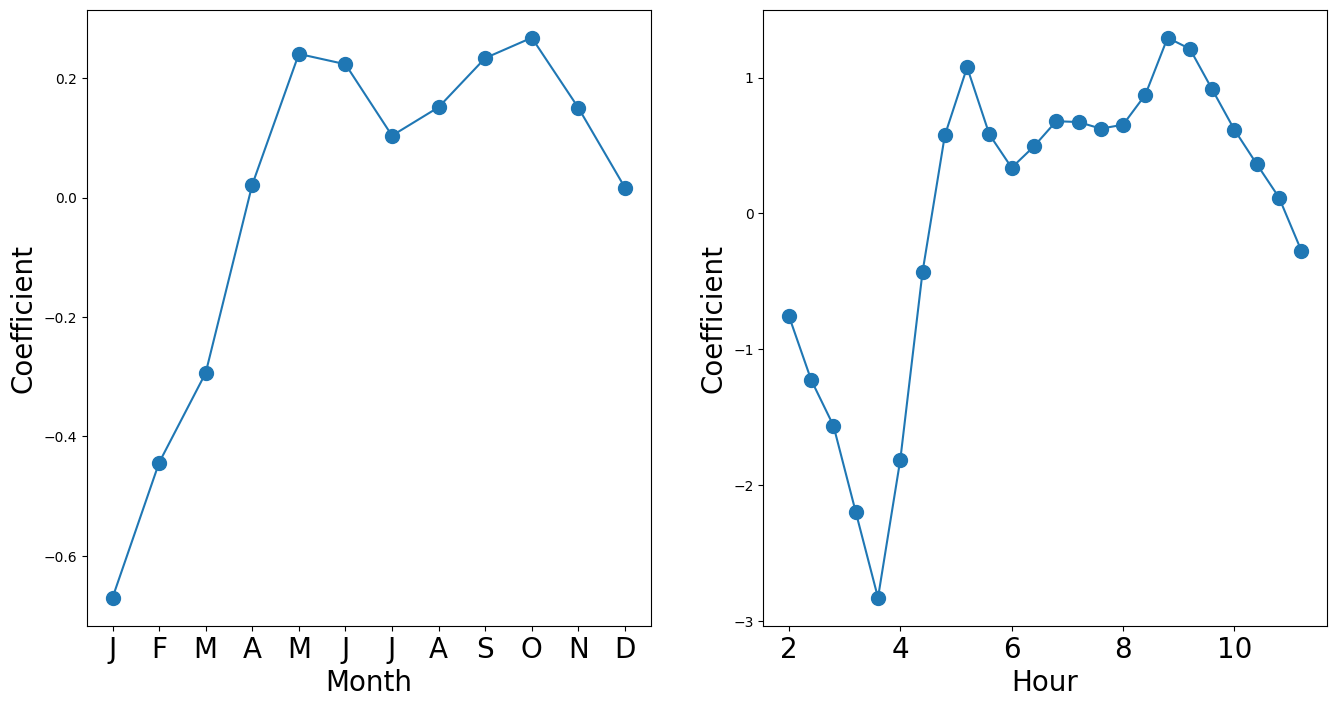

In [73]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month ,
pd.Series([-coef_month.sum()],
index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr ,
pd.Series([-coef_hr.sum()],
index=['hr[23]'])])

fig_pois , (ax_month , ax_hr) = subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

- 일반선형회귀직선과 포아송 분포를 가정한 평균직선을 비교

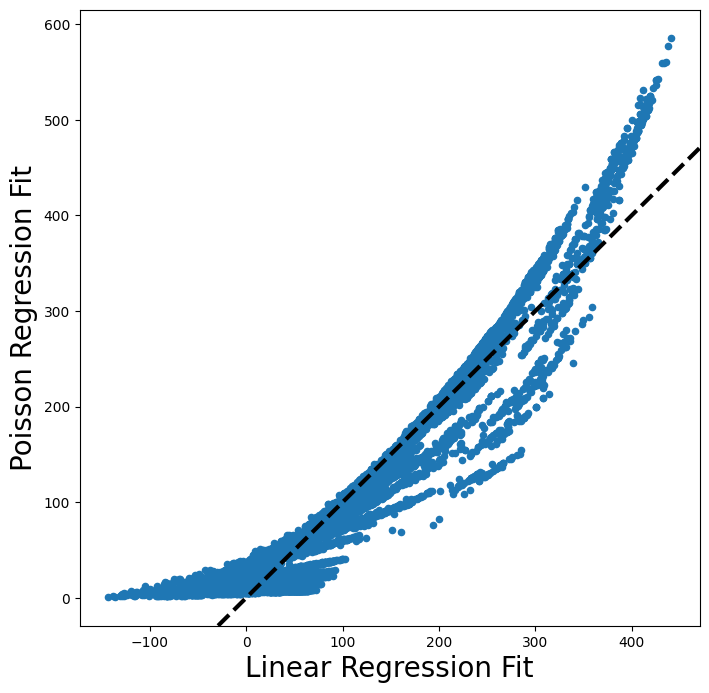

In [74]:
fig , ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues ,
M_pois.fittedvalues ,
s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
linestyle='--', slope=1);